In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Display first row
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x13125de40>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

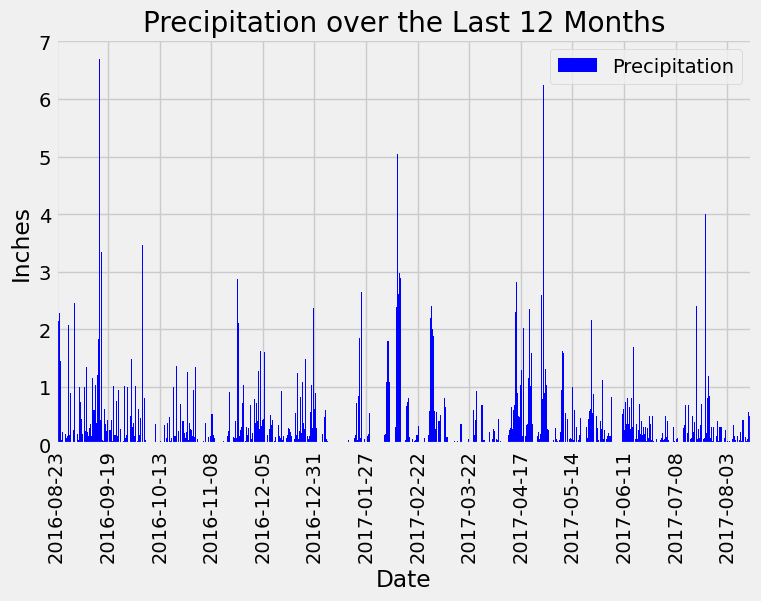

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

# Create lists to store the date and precipitation values
dates = []
precipitation = []

# Iterate through the query results and append non-null values to the lists
for date, prcp in results:
    if prcp is not None:
        dates.append(date)
        precipitation.append(prcp)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_last_year = pd.DataFrame({"Date": dates, "Precipitation": precipitation})
prcp_last_year.set_index("Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
last_12_months = prcp_last_year.plot(kind="bar", color=["blue"], figsize=(8,5),
                                   title="Precipitation over the Last 12 Months",
                                   xlabel="Date",
                                   ylabel="Inches",
                                   width = 3)

# # Set the x-tick frequency to show every nth label
n = 150  # Set the interval for showing x-tick labels
plt.xticks(range(0, len(prcp_last_year.index), n), prcp_last_year.index[::n])

plt.savefig("../Images/prcp_graph.png")

plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_last_year["Precipitation"].describe()

summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
first_row_station = session.query(Station).first()
first_row_station.__dict__
station_count = session.query(Station).distinct().count()
print(station_count)

9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.id)) \
                        .group_by(Measurement.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
avgs = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
active_station = session.query(*avgs).\
        filter(Measurement.station == 'USC00519281')\
        .all()
active_station

[(54.0, 85.0, 71.66378066378067)]

In [16]:
session.query(Measurement.date).\
filter(Measurement.station == 'USC00519281').\
order_by(Measurement.date.desc()).first()

('2017-08-18',)

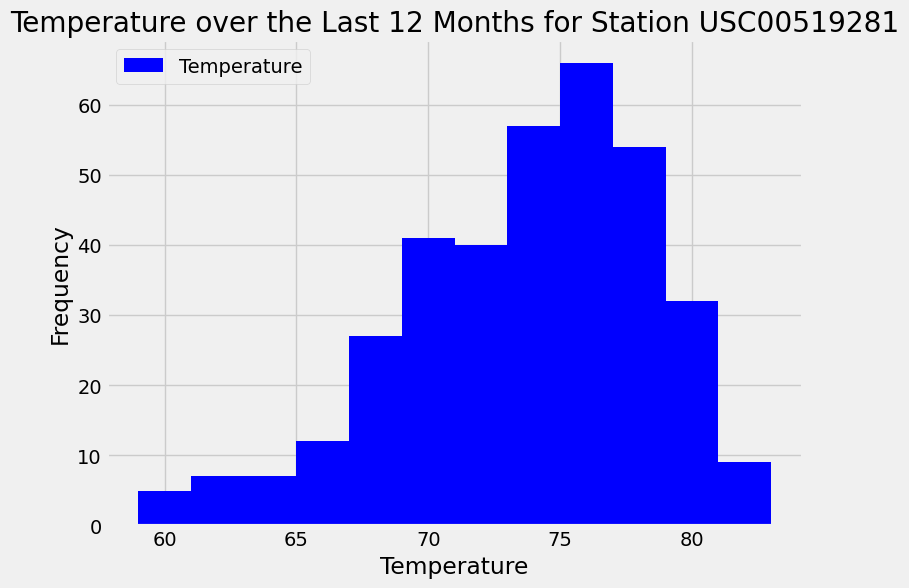

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_date_2 = dt.date(2017, 8, 18) - dt.timedelta(days = 365)
results_2 = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date_2).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()

# Create lists to store the date and temperature values
dates = []
temperature = []

# Iterate through the query results and append non-null values to the lists
for date, temp in results_2:
    if temp is not None:
        dates.append(date)
        temperature.append(temp)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
temp_last_year = pd.DataFrame({"Date": dates, "Temperature": temperature})
temp_last_year.set_index("Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
temp_12_months = temp_last_year.plot(kind="hist", color=["blue"], figsize=(8,6),
                                   title="Temperature over the Last 12 Months for Station USC00519281",
                                   xlabel="Temperature",
                                   ylabel="Frequency",
                                    bins = 12)
plt.savefig("../Images/tobs_graph.png")
plt.show()


# Close Session

In [18]:
# Close Session
session.close()